In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision import transforms
from utils.model import IntelModel
from utils.utils import basetransforms,traintransforms
from utils.initvars import rootf,batch_size,device


# Basic EDA

In [2]:
trainDataset = datasets.ImageFolder(root=rootf+'train/seg_train', transform=traintransforms)
valSplit = 0.2
trainDataset, valDataset = random_split(trainDataset, [int((1-valSplit)*len(trainDataset))+1, int(valSplit*len(trainDataset))])

trainLoader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True, num_workers=8)
valLoader = DataLoader(valDataset, batch_size=batch_size, shuffle=False, num_workers=8) 
testDataset = datasets.ImageFolder(root=rootf+'test/seg_test', transform=basetransforms)
testLoader = DataLoader(testDataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [3]:
class_names = trainDataset.dataset.classes
num_classes = len(class_names)
# Target-validation distribution is just too akward to plot

In [4]:
# Load batch of image
batch = next(iter(trainLoader))
images, labels = batch
images.shape

torch.Size([64, 3, 128, 128])

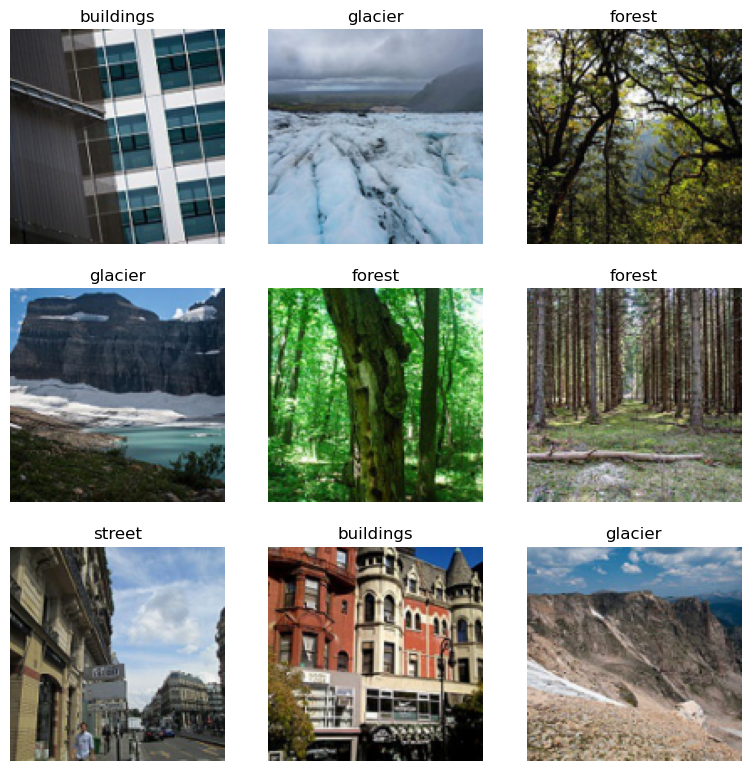

In [5]:
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title(class_names[labels[i]],fontdict={'fontsize': 12})
plt.tight_layout()

In [6]:
@torch.no_grad()
def showImage(img,labels,model):
    figure = plt.figure(figsize=(8, 8))
    model.eval()
    img = img.to(device)
    pred = model(img)
    pred = torch.argmax(pred, dim=1)
    pred = pred.cpu().numpy()
    pred = np.squeeze(pred)
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(img[i].detach().cpu().permute(1, 2, 0))
        plt.axis('off')
        plt.title(class_names[pred[i]]+f'\nTrue:{class_names[labels[i]]} ',fontdict={'fontsize': 12},color ='red' if pred[i] != labels[i] else 'green')

    plt.axis('off')
    return figure

# Model fitting

In [7]:
@torch.no_grad()
def plotConfusionMatrix(model,imgs,labels):
    model.eval()
    imgs = imgs.to(device)
    labels = labels.to(device)
    preds = model(imgs)
    preds = torch.argmax(preds, dim=1)
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    confusionMatrix = np.zeros((num_classes,num_classes))
    for t,p in zip(labels,preds):
        confusionMatrix[t,p] += 1
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(confusionMatrix, cmap='Blues')
    plt.xticks(np.arange(num_classes), class_names, rotation=90)
    plt.yticks(np.arange(num_classes), class_names)
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.colorbar()
    return figure

In [8]:
lossF = nn.CrossEntropyLoss()
model = IntelModel(3, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
mymetrics = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}


In [9]:
numEpochs = 30
trainSteps = len(trainLoader)
valSteps = len(valLoader)//valLoader.batch_size
writer = SummaryWriter()
writer.add_graph(model, images.to(device))

In [ ]:
for epoch in range(numEpochs):
    print('Epoch:', epoch)
    model.train()
    train_loss = 0.0
    train_accs = 0.0
    for trainingStep, (images, labels) in enumerate(trainLoader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = lossF(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        writer.add_scalar('Loss/train_step', loss, epoch*trainSteps+trainingStep)
        
        preds = torch.argmax(outputs, dim=1)
        train_acc = torch.sum(preds == labels).item()/batch[0].shape[0]
        train_accs += train_acc
        writer.add_scalar('Accuracy/train_step', train_acc, epoch*trainSteps+trainingStep)
        
        confmx = plotConfusionMatrix(model,images,labels)
        writer.add_figure('Confusion Matrix/train', confmx, epoch*trainSteps+trainingStep)
        
        sampleImages = showImage(images,labels,model)
        writer.add_figure('Images/train', sampleImages, epoch*trainSteps+trainingStep)
        
    
    writer.add_scalar('Loss/train_epoch', train_loss/trainSteps, epoch)

    writer.add_scalar('Accuracy/train_epoch', train_accs/trainSteps, epoch)
    print(f'Training Loss: {train_loss/trainSteps} Training Accuracy: {train_accs/trainSteps}')


Epoch: 0
Training Loss: 1.0924296643246303 Training Accuracy: 0.5720880681818182
Epoch: 1
Training Loss: 1.8074309785257687 Training Accuracy: 0.5502485795454546
Epoch: 2
Training Loss: 6.027522372251207 Training Accuracy: 0.5601029829545454
Epoch: 3
Training Loss: 23.005273293365132 Training Accuracy: 0.17311789772727273
Epoch: 4
Training Loss: 12.939070662314242 Training Accuracy: 0.1688565340909091
Epoch: 5
Training Loss: 10.63601506095041 Training Accuracy: 0.17906605113636365
Epoch: 6
Training Loss: 8.284274903888052 Training Accuracy: 0.17578125
Epoch: 7
Training Loss: 9.677079930224203 Training Accuracy: 0.19868607954545456
Epoch: 8
Training Loss: 4.729034374383363 Training Accuracy: 0.3034446022727273
Epoch: 9
Training Loss: 5.082393689589067 Training Accuracy: 0.4385653409090909
Epoch: 10
Training Loss: 6.081869605589997 Training Accuracy: 0.42329545454545453
Epoch: 11
Training Loss: 7.119192858311263 Training Accuracy: 0.45862926136363635
Epoch: 12
Training Loss: 5.2083833475

# Evaluation